In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import img_to_array
from keras import regularizers
import pandas as pd
import numpy as np
import keras
import skimage
from skimage import color
from skimage.transform import resize, rotate
from skimage.util import crop
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot


Mounted at /content/drive


In [3]:
SIZE = 256
# /content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos
image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_photos/'
img_array = []

sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_training_cropped_sketches/'
sketch_array = []

test_image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos/'
test_img_array = []

test_sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_sketches/'
test_sketch_array = []

# Image and their corresponding file names in a sorted manner based on their names
image_file = sorted(os.listdir(image_path))
sketch_file = sorted(os.listdir(sketch_path))
test_image_file = sorted(os.listdir(test_image_path))
test_sketch_file = sorted(os.listdir(test_sketch_path))

def image_preprocessing(file_name, img_path, size):
  storage_array = []
  for img_file in tqdm(file_name):
    x = img_path + img_file
    c = (cv2.resize(cv2.imread(x).astype('float32'),(SIZE,SIZE)))/255.0
    #c = color.rgb2gray(c)
    storage_array.append(c)

  # Returning storage array where we have stored all our pre-processed images
  return np.array(storage_array)


img_array = image_preprocessing(image_file, image_path, SIZE)
sketch_array = image_preprocessing(sketch_file, sketch_path, SIZE)
test_img_array = image_preprocessing(test_image_file, test_image_path, SIZE)
test_sketch_array = image_preprocessing(test_sketch_file, test_sketch_path, SIZE)

# Print the number of colored and sketch images present
print("Total number of Training Colored images:",len(img_array))
print("Total number of Training sketch images:",len(sketch_array))
print("Total number of Testing Colored images:",len(test_img_array))
print("Total number of Testing sketch images:",len(test_sketch_array))

x_train = img_array
y_train = sketch_array
x_test = test_img_array
y_test = test_sketch_array

#x_train.shape, y_train.shape, x_test.shape, y_test.shape

#dataset1 = [y_train, x_train]
dataset1 = [x_train, y_train]

100%|██████████| 100/100 [00:23<00:00,  4.31it/s]

Total number of Training Colored images: 88
Total number of Training sketch images: 88
Total number of Testing Colored images: 100
Total number of Testing sketch images: 100


In [4]:
#!pip install keras==2.3.1

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ejjq39w8
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ejjq39w8
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=ac7b5ada9fc331acbc3a2261ba932ed2ecd768922ea0edf1018025fda5419fb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-boy683hw/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [7]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer='adam', loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	#opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer='adam')
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)



In [10]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 20, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# Storing loss
		temp_loss_store.append((i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)


In [11]:
# load image data
#dataset = load_real_samples('horse2zebra_256.npz')
dataset = dataset1
temp_loss_store = []
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
>1, dA[2.103,12.245] dB[1.631,7.148] g[22.623,24.198]
>2, dA[10.043,24.440] dB[14.424,33.538] g[72.142,83.983]
>3, dA[34.681,12.136] dB[25.373,7.561] g[64.452,42.172]
>4, dA[15.702,10.689] dB[17.197,12.852] g[51.271,52.393]
>5, dA[4.065,2.470] dB[3.226,2.086] g[29.848,28.303]
>6, dA[1.936,1.265] dB[1.437,1.226] g[23.993,24.081]
>7, dA[1.746,1.229] dB[0.620,2.111] g[22.923,23.065]
>8, dA[1.239,1.176] dB[0.748,1.405] g[23.348,22.562]
>9, dA[0.524,0.536] dB[0.585,0.450] g[20.532,19.834]
>10, dA[0.223,0.825] dB[0.559,0.426] g[19.786,19.936]
>11, dA[0.515,0.762] dB[0.492,0.314] g[21.260,20.620]
>12, dA[0.512,0.541] dB[0.329,0.400] g[20.056,19.581]
>13, dA[0.328,0.437] dB[0.511,0.549] g[20.863,20.030]
>14, dA[0.203,0.312] dB[0.551,0.323] g[20.061,18.733]
>15, dA[0.295,0.412] dB[0.358,0.198] g[19.137,18.389]
>16, dA[0.400,0.263] dB[0.277,0.120] g[19.905,19.207]
>17, dA[0.306,0.109] dB[0.243,0.137] g[19.545,18.562]
>18, dA[0.350,0.093] dB[0.145,0.142]

#g_model_AtoB_001760.h5 and g_model_BtoA_001760.h5

# Photo2Sketch

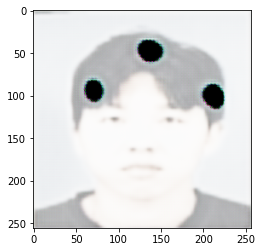

In [12]:
# example of using saved cyclegan models for image translation
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot

# load an image to the preferred size
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

# load the image
#image_src = load_image('horse2zebra/trainA/n02381460_541.jpg')
#xxx = test_sketch_path + test_sketch_file[20]
xxx = test_image_path + test_image_file[23]
#xxx = (test_sketch_path + test_sketch_file[23])
image_src = load_image(xxx)

# g_model_AtoB_001760.h5 and g_model_BtoA_001760.h5
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_001760.h5', cust)

# translate image
image_tar = model_AtoB.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0

# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()

# Sketch2Photo

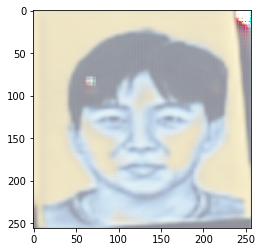

In [13]:
# load an image to the preferred size
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

# load the image
#image_src = load_image('horse2zebra/trainA/n02381460_541.jpg')
#xxx = test_sketch_path + test_sketch_file[20]
#xxx = test_image_path + test_image_file[23]
xxx = (test_sketch_path + test_sketch_file[23])
image_src = load_image(xxx)

# g_model_AtoB_001760.h5 and g_model_BtoA_001760.h5
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('g_model_BtoA_001760.h5', cust)

# translate image
image_tar = model_BtoA.predict(image_src)
# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0

# plot the translated image
pyplot.imshow(image_tar[0])
pyplot.show()

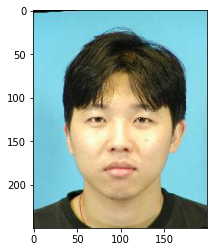

In [14]:
# Original Image
v1 = plt.imread(test_image_path + test_image_file[23])
plt.imshow(v1)


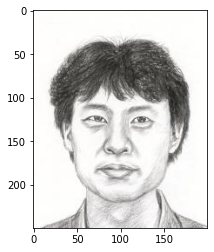

In [15]:
# Original Sketch
v2 = plt.imread(test_sketch_path + test_sketch_file[20])
plt.imshow(v2)

In [16]:
# (i+1, 
# dA_loss1,dA_loss2, 
# dB_loss1,dB_loss2, 
# g_loss1,g_loss2)
# =========================================
# steps, 
# update discriminator for A -> [real/fake]
# update discriminator for B -> [real/fake]
# update generator A->B via adversarial and cycle loss / update generator B->A via adversarial and cycle loss
temp_loss_store[0]

(1,
 2.1031320095062256,
 12.245438575744629,
 1.6307340860366821,
 7.147623062133789,
 22.623313903808594,
 24.19788932800293)

In [17]:
steps = [i[0] for i in temp_loss_store]
da1 = [i[1] for i in temp_loss_store]
da2 = [i[2] for i in temp_loss_store]
db1 = [i[3] for i in temp_loss_store]
db2 = [i[4] for i in temp_loss_store]
g1 = [i[5] for i in temp_loss_store]
g2 = [i[6] for i in temp_loss_store]

Text(0, 0.5, 'Loss')

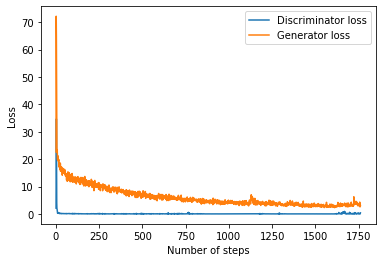

In [26]:
plt.plot(steps, da1)

plt.plot(steps, g1)
#plt.plot(steps, g2)

plt.legend(['Discriminator loss', 'Generator loss'])
plt.xlabel("Number of steps")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

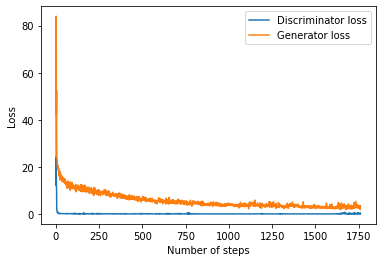

In [29]:
plt.plot(steps, da2)

#plt.plot(steps, g1)
plt.plot(steps, g2)

plt.legend(['Discriminator loss', 'Generator loss'])
plt.xlabel("Number of steps")
plt.ylabel("Loss")